# Word2vec implementation in Keras

In [45]:
# Imports
import requests
import collections
import os
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)

import tensorflow as tf
tf.random.set_seed(rng_seed)
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, dot, Embedding
from tensorflow.keras.preprocessing.sequence import skipgrams, make_sampling_table
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

### Utility functions

In [2]:
def load_content_from_url(url: str, data_dir: str = 'data'):
    '''
    TODO: Docs
    '''
    filename = f'{data_dir}{os.path.sep}{os.path.basename(url)}'
    
    # Download file if not present
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb', encoding='utf-8-sig') as f:
            f.write(r.content)
        return r.text
    else:
        with open(filename, 'r', encoding='utf-8-sig') as f:
            content = f.read()
    
    return content

In [3]:
def build_dataset(text: str, max_vocab_size: int, context_window_size: int, seed: int = rng_seed):
    '''
    TODO: Docs
    '''
    # Tokenize the text
    tokenizer = Tokenizer(max_vocab_size)
    tokenizer.fit_on_texts([text])
    text_tokenized = text_to_word_sequence(text)
    
    # Extract word dictionary
    word_dict = tokenizer.word_index
    num_words = len(word_dict)
    rev_word_dict = tokenizer.index_word
    data = [word_dict[word] for word in text_tokenized]
    
    # Create data samples for valid context words and negative samples
    sampling_table = make_sampling_table(num_words + 1)
    pairs, labels = skipgrams(data, num_words, window_size=context_window_size, sampling_table=sampling_table, seed=seed)
    pairs = np.array(pairs)
    labels = np.array(labels)
    
    return data, (pairs, labels), word_dict, rev_word_dict, num_words

In [4]:
# Constants
max_vocab_size = 10000
context_window_size = 10
vector_dim = 300
num_epochs = 20
batch_size = 128

In [5]:
# Build dataset
# TODO: Build separate datasets for train, val and test.
# Otherwhise the datasets will become too corrolated, due to the fact that
# we create skipgrams which might overlap a lot.
# TODO: Look into COVID-19 dataset from kaggle:
# https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
book_url = 'http://www.gutenberg.org/cache/epub/78/pg78.txt'
book_content = load_content_from_url(book_url)
book_data, (book_data_pairs, book_data_labels), book_dictionary, rev_book_dictionary, real_vocab_size = build_dataset(book_content, max_vocab_size, context_window_size)
del book_content # Save memory

In [39]:
# Split data into train/test
X_train, X_val, y_train, y_val = train_test_split(book_data_pairs, book_data_labels, test_size=0.04, random_state=rng_seed)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=rng_seed)

In [40]:
len(X_val)

10351

In [7]:
# Sanity checking
for i, target, context, label in zip(range(10), X_train[:, 0], X_train[:, 1], book_data_labels):
    print(f'Pair #{i + 1} - {rev_book_dictionary[target]} + {rev_book_dictionary[context]} --> {label}')

Pair #1 - fashioned + assortment --> 1
Pair #2 - perilous + uniformly --> 0
Pair #3 - pointed + scarce --> 0
Pair #4 - arduous + outburst --> 1
Pair #5 - he + intact --> 0
Pair #6 - legally + mutinied --> 0
Pair #7 - should + spring --> 1
Pair #8 - concerned + defiance --> 1
Pair #9 - gurgles + hysterical --> 0
Pair #10 - shores + mirror --> 1


In [8]:
# Create the model
# TODO: Add regularization to layers
def build_model_embedding(vocab_size: int, vector_dim: int, optimizer='adam'):
    '''
    TODO: Docs
    '''
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer
    embedding = Embedding(vocab_size + 1, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Create (slower) model using Dense instead of Embedding layer
def build_model_dense(vocab_size: int, vector_dim: int, optimizer='adam'):
    '''
    TODO: Docs
    '''
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer using Dense layers
    # TODO: Implement embedding myself.
    # https://stackoverflow.com/questions/47868265/what-is-the-difference-between-an-embedding-layer-and-a-dense-layer
    embedding = Embedding(vocab_size + 1, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [9]:
w2v_model = build_model_embedding(real_vocab_size, vector_dim)
w2v_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_target (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       2327700     input_target[0][0]               
                                                                 input_context[0][0]              
__________________________________________________________________________________________________
target_word_vector (Reshape)    (None, 300, 1)       0           embedding[0][0]              

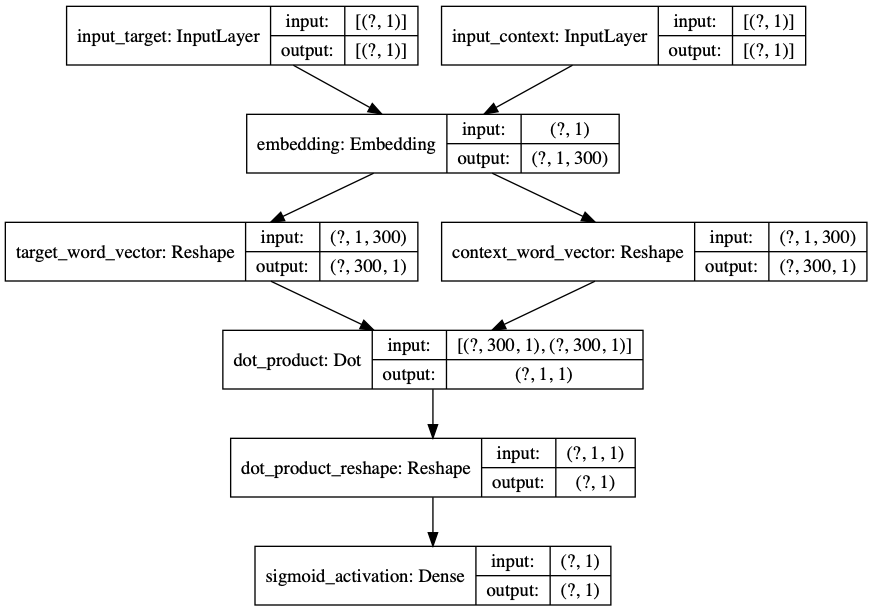

In [10]:
# Visualize model using PyDot and GraphViz
plot_model(w2v_model, show_shapes=True, to_file='word2vec_model.png')

In [11]:
# Load model from file
#w2v_model = load_model('word2vec_model.h5')

In [12]:
class IntermediateUMAPReductionCallback(Callback):
    '''
    TODO: Docs
    '''
    
    def __init__(self, plot_embedding: bool = True, data: list = None, rev_data_dictionary: dict = None):
        '''
        TODO: Docs
        '''
        self.plot_embedding = plot_embedding
        self.data = data
        self.rev_data_dictionary = rev_data_dictionary
        self.embeddings = []
    
    def get_embedding(self, epoch: int):
        '''
        TODO: Docs
        '''
        assert epoch < len(self.embeddings), f'Invalid epoch number: {epoch}'
        return self.embeddings[epoch]
    
    def __plot_embedding__(self, epoch: int, num_words: int = 100):
        '''
        TODO: Docs
        '''
        assert self.data != None, 'Data is required for plotting'
        assert self.rev_data_dictionary != None, 'Reversed data dictionary is required for plotting'
        embedding = self.get_embedding(epoch)
        
        # Plot embedded vectors in 2D
        plt.figure(figsize=(5, 5))
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.25)

        # Annotate
        for word_i in self.data[:num_words]:
            word = self.rev_data_dictionary[word_i]
            word_vec = embedding[word_i]
            plt.annotate(word, (word_vec[0], word_vec[1]))
        plt.show()
    
    def on_epoch_end(self, epoch, logs={}):
        '''
        TODO: Docs
        '''
        print(f'Creating word embeddings...')
        
        # Create intermediate UMAP word embeddings
        word_embeddings = self.model.layers[2].get_weights()[0]
        word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)
        self.embeddings.append(word_embeddings_2d)
        
        if self.plot_embedding:
            self.__plot_embedding__(epoch)

Train on 507208 samples, validate on 5176 samples
Epoch 1/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.7483
Epoch 00001: val_loss improved from inf to 0.43045, saving model to checkpoints/model-best-01.h5
Creating word embeddings...


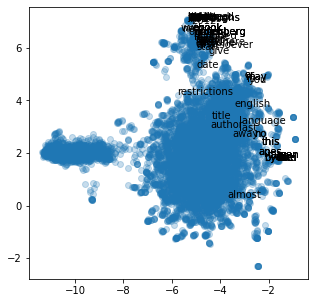

507208/507208 [==============================] - 86s 169us/sample - loss: 0.5264 - accuracy: 0.7483 - val_loss: 0.4305 - val_accuracy: 0.8232
Epoch 2/20
506880/507208 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9262
Epoch 00002: val_loss improved from 0.43045 to 0.41695, saving model to checkpoints/model-best-02.h5
Creating word embeddings...


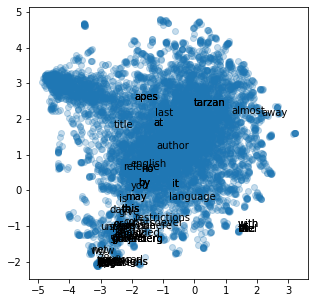

507208/507208 [==============================] - 77s 152us/sample - loss: 0.2355 - accuracy: 0.9262 - val_loss: 0.4169 - val_accuracy: 0.8354
Epoch 3/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9763
Epoch 00003: val_loss did not improve from 0.41695
Creating word embeddings...


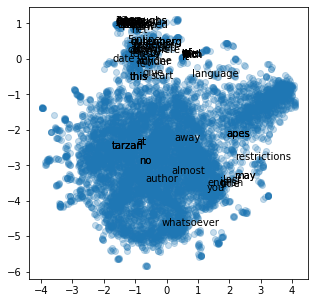

507208/507208 [==============================] - 77s 152us/sample - loss: 0.1002 - accuracy: 0.9763 - val_loss: 0.4856 - val_accuracy: 0.8207
Epoch 4/20
506752/507208 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9815
Epoch 00004: val_loss did not improve from 0.41695
Creating word embeddings...


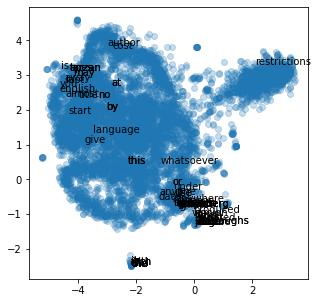

507208/507208 [==============================] - 78s 155us/sample - loss: 0.0787 - accuracy: 0.9815 - val_loss: 0.5188 - val_accuracy: 0.8089
Epoch 5/20
506752/507208 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9823
Epoch 00005: val_loss did not improve from 0.41695
Creating word embeddings...


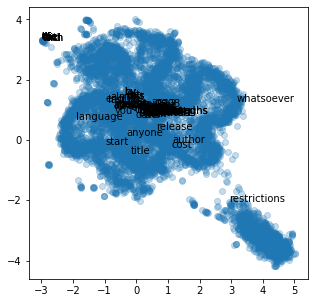

507208/507208 [==============================] - 77s 152us/sample - loss: 0.0706 - accuracy: 0.9823 - val_loss: 0.5466 - val_accuracy: 0.8039
Epoch 6/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9827
Epoch 00006: val_loss did not improve from 0.41695
Creating word embeddings...


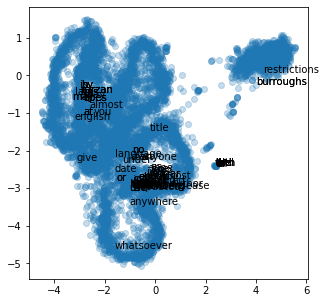

507208/507208 [==============================] - 79s 156us/sample - loss: 0.0643 - accuracy: 0.9827 - val_loss: 0.5974 - val_accuracy: 0.7848
Epoch 7/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9830
Epoch 00007: val_loss did not improve from 0.41695
Creating word embeddings...


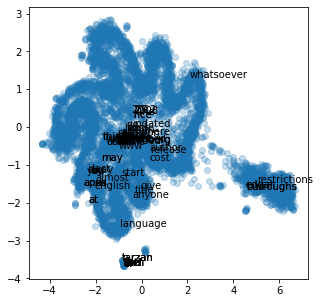

507208/507208 [==============================] - 77s 152us/sample - loss: 0.0597 - accuracy: 0.9830 - val_loss: 0.6184 - val_accuracy: 0.7784
Epoch 8/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.0564 - accuracy: 0.9831
Epoch 00008: val_loss did not improve from 0.41695
Creating word embeddings...


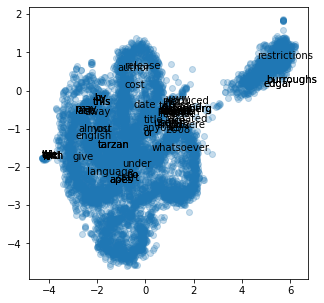

507208/507208 [==============================] - 78s 153us/sample - loss: 0.0565 - accuracy: 0.9831 - val_loss: 0.6594 - val_accuracy: 0.7668
Epoch 9/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9833
Epoch 00009: val_loss did not improve from 0.41695
Creating word embeddings...


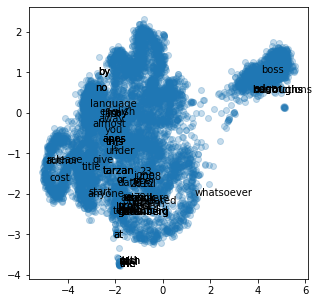

507208/507208 [==============================] - 86s 170us/sample - loss: 0.0532 - accuracy: 0.9833 - val_loss: 0.6952 - val_accuracy: 0.7597
Epoch 10/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9833
Epoch 00010: val_loss did not improve from 0.41695
Creating word embeddings...


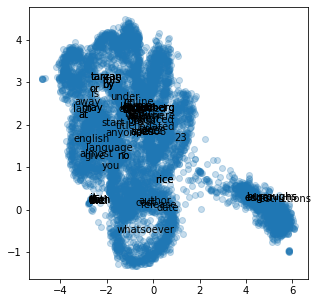

507208/507208 [==============================] - 83s 164us/sample - loss: 0.0508 - accuracy: 0.9833 - val_loss: 0.7365 - val_accuracy: 0.7579
Epoch 11/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9835
Epoch 00011: val_loss did not improve from 0.41695
Creating word embeddings...


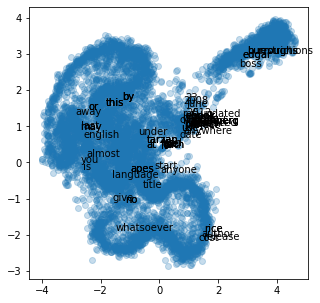

507208/507208 [==============================] - 82s 161us/sample - loss: 0.0490 - accuracy: 0.9835 - val_loss: 0.7565 - val_accuracy: 0.7494
Epoch 12/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9835
Epoch 00012: val_loss did not improve from 0.41695
Creating word embeddings...


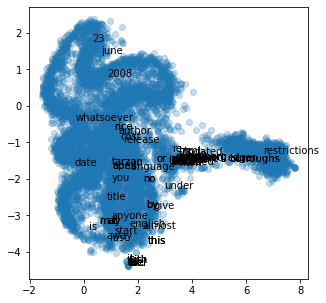

507208/507208 [==============================] - 77s 152us/sample - loss: 0.0472 - accuracy: 0.9835 - val_loss: 0.7776 - val_accuracy: 0.7440
Epoch 13/20
506880/507208 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9837
Epoch 00013: val_loss did not improve from 0.41695
Creating word embeddings...


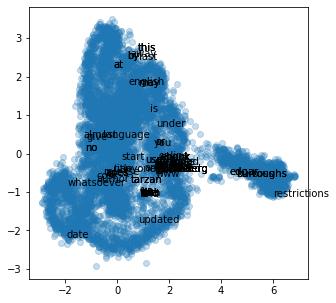

507208/507208 [==============================] - 76s 149us/sample - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.8168 - val_accuracy: 0.7411
Epoch 14/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9837
Epoch 00014: val_loss did not improve from 0.41695
Creating word embeddings...


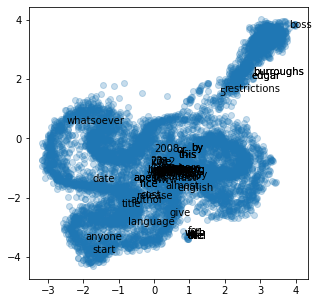

507208/507208 [==============================] - 77s 151us/sample - loss: 0.0441 - accuracy: 0.9837 - val_loss: 0.8313 - val_accuracy: 0.7372
Epoch 15/20
507008/507208 [============================>.] - ETA: 0s - loss: 0.0429 - accuracy: 0.9837
Epoch 00015: val_loss did not improve from 0.41695
Creating word embeddings...


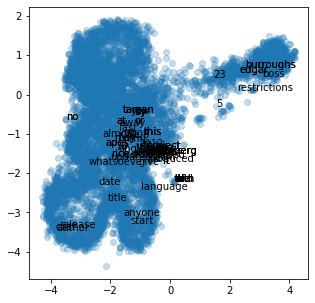

507208/507208 [==============================] - 78s 153us/sample - loss: 0.0429 - accuracy: 0.9837 - val_loss: 0.8548 - val_accuracy: 0.7340
Epoch 16/20
506880/507208 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9838
Epoch 00016: val_loss did not improve from 0.41695
Creating word embeddings...


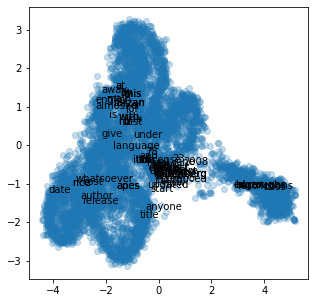

507208/507208 [==============================] - 76s 150us/sample - loss: 0.0418 - accuracy: 0.9838 - val_loss: 0.8762 - val_accuracy: 0.7307
Epoch 17/20
506752/507208 [============================>.] - ETA: 0s - loss: 0.0407 - accuracy: 0.9839
Epoch 00017: val_loss did not improve from 0.41695
Creating word embeddings...


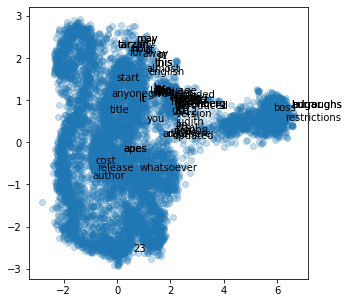

507208/507208 [==============================] - 76s 150us/sample - loss: 0.0407 - accuracy: 0.9839 - val_loss: 0.9018 - val_accuracy: 0.7270
Epoch 18/20
507136/507208 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9839
Epoch 00018: val_loss did not improve from 0.41695
Creating word embeddings...


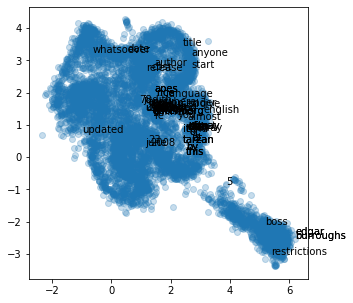

507208/507208 [==============================] - 79s 156us/sample - loss: 0.0398 - accuracy: 0.9839 - val_loss: 0.9129 - val_accuracy: 0.7280
Epoch 19/20
506752/507208 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9840
Epoch 00019: val_loss did not improve from 0.41695
Creating word embeddings...


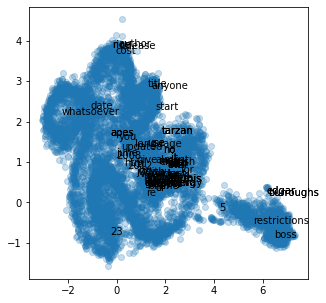

507208/507208 [==============================] - 76s 149us/sample - loss: 0.0390 - accuracy: 0.9840 - val_loss: 0.9275 - val_accuracy: 0.7249
Epoch 20/20
506880/507208 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9840
Epoch 00020: val_loss did not improve from 0.41695
Creating word embeddings...


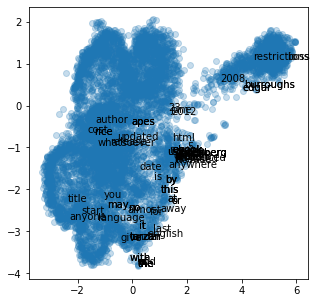

507208/507208 [==============================] - 75s 148us/sample - loss: 0.0382 - accuracy: 0.9840 - val_loss: 0.9653 - val_accuracy: 0.7255


In [14]:
# Define callbacks
checkpoint = ModelCheckpoint('checkpoints/model-best-{epoch:02d}.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='auto')  
umap_reduc = IntermediateUMAPReductionCallback(data=book_data, rev_data_dictionary=rev_book_dictionary)
cb = [checkpoint, umap_reduc]

# Uncomment to fit model
model_hist = w2v_model.fit(list(X_train.T), y_train, batch_size=batch_size, epochs=num_epochs, callbacks=cb, validation_data=(list(X_val.T), y_val))

In [ ]:
# TODO: Run a UMAP on all embeddings at once ((m x n) x 300 matrix)
# to get a less biased result. The plots above from training might be too correlated.

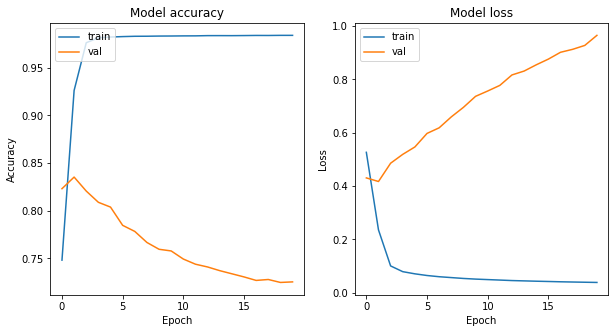

In [15]:
# Summarize history for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Evaluate train accuracy
y_train_pred = w2v_model.predict(list(X_train.T))
y_train_acc = roc_auc_score(y_train, y_train_pred)
print(f'Train accuracy: {y_train_acc}')

Train accuracy: 0.9995878920130815


In [17]:
# Evaluate test accuracy
y_test_pred = w2v_model.predict(list(X_test.T))
y_test_acc = roc_auc_score(y_test, y_test_pred)
print(f'Test accuracy: {y_test_acc}')

Test accuracy: 0.8124659958302153


In [18]:
# Save last model to file
w2v_model.save('checkpoints/last_model.h5')

## Analyze word embeddings

In [19]:
# Load best model from file
#best_model_path = 'checkpoints/last_model.h5'
best_model_path = 'checkpoints/model-best-02.h5'
w2v_model = load_model(best_model_path)

In [47]:
# Extract the learned embeddings from the NN
word_embeddings = w2v_model.layers[2].get_weights()[0]
word_embeddings_lst = list(word_embeddings)

In [57]:
word_embeddings_2d = PCA(n_components=2).fit_transform(word_embeddings)

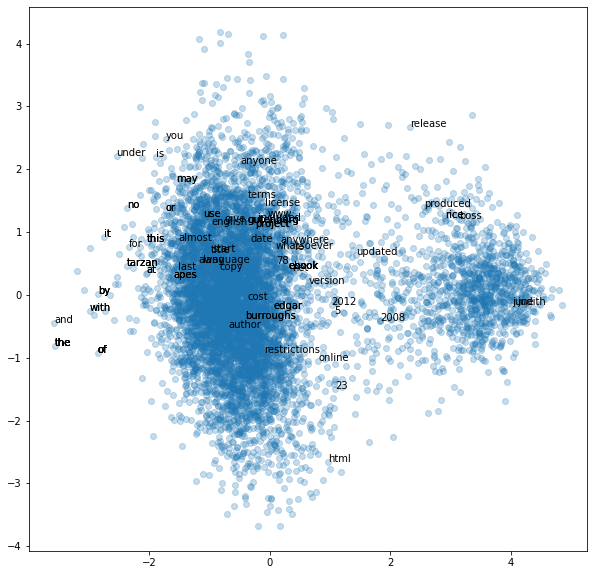

In [58]:
# Plot embedded vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.25)

# Annotate
for word_i in book_data[:100]:
    word = rev_book_dictionary[word_i]
    word_vec = word_embeddings_2d[word_i]
    plt.annotate(word, (word_vec[0], word_vec[1]))
plt.show()

In [52]:
# Tarzan - Man + Woman = Jane?
tarzan_vec = word_embeddings[book_dictionary['tarzan']]
man_vec = word_embeddings[book_dictionary['man']]
woman_vec = word_embeddings[book_dictionary['woman']]
jane_vec = word_embeddings[book_dictionary['jane']]
jane_vec_pred = tarzan_vec - man_vec + woman_vec

### Utility functions

In [59]:
def distance(a: np.ndarray, b: np.ndarray):
    '''
    TODO: Docs
    '''
    return np.linalg.norm(a - b)

def closest(target: np.ndarray, word_embeddings: np.ndarray, rev_book_dictionary: dict, n: int=10):
    '''
    TODO: Docs
    '''
    target_mat = np.tile(target, (word_embeddings.shape[0], 1))
    diff = word_embeddings - target_mat
    distances = np.linalg.norm(diff, axis=1)
    sorted_order = np.argsort(distances)[:n]
    closest_words = [rev_book_dictionary[idx + 1] for idx in sorted_order]
    return closest_words

In [60]:
# TODO: Find top words close to jane_vec_pred
print(closest(jane_vec_pred, word_embeddings, rev_book_dictionary))

['why', 'him', 'francs', 'patiently', 'confiscated', 'binary', 'vegetation', 'lightning', 'the', 'killed']


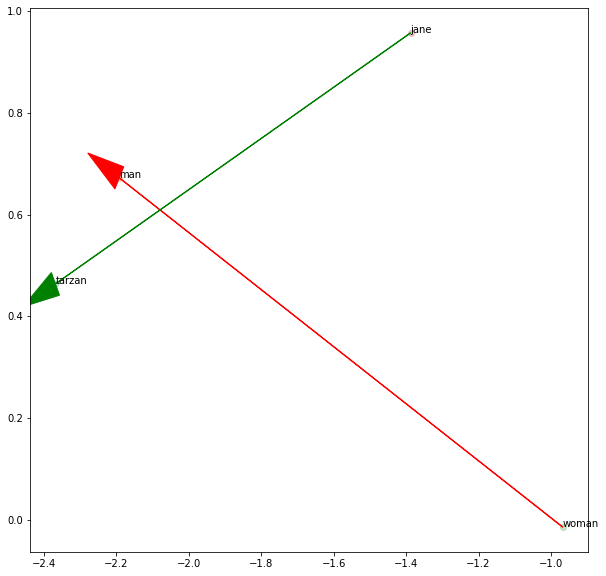

In [61]:
# TODO: Create utility function 'arrow_plot'
# Plotting tarzan, man, woman, jane
target_words = ['tarzan', 'man', 'woman', 'jane']
target_word_vecs = [word_embeddings_2d[book_dictionary[word]] for word in target_words]

# TODO: Ensure that we use a dim. reduc. method that preserves parallelism, i.e PCA
plt.figure(figsize=(10, 10))
for word, word_vec in zip(target_words, target_word_vecs):
    plt.scatter(word_vec[0], word_vec[1], alpha=0.25)
    plt.annotate(word, (word_vec[0], word_vec[1]))

man_to_woman = target_word_vecs[target_words.index('man')] - target_word_vecs[target_words.index('woman')]
tarzan_to_jane = target_word_vecs[target_words.index('tarzan')] - target_word_vecs[target_words.index('jane')]
plt.arrow(*target_word_vecs[target_words.index('woman')], *man_to_woman, head_width=0.05, head_length=0.1, color='r')
plt.arrow(*target_word_vecs[target_words.index('jane')], *tarzan_to_jane, head_width=0.05, head_length=0.1, color='g')
    
plt.show()

# Scrapyard

In [24]:
'''
def build_dataset(words: list, num_words: int = -1):
    
    # Create a dictionary for word counts
    count = [['UNK', -1]]
    if num_words == -1:
        num_words = len(words)
        
    # TODO: Fix words
    count.extend(collections.Counter(words).most_common(num_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary
'''

"\ndef build_dataset(words: list, num_words: int = -1):\n    \n    # Create a dictionary for word counts\n    count = [['UNK', -1]]\n    if num_words == -1:\n        num_words = len(words)\n        \n    # TODO: Fix words\n    count.extend(collections.Counter(words).most_common(num_words - 1))\n    dictionary = dict()\n    for word, _ in count:\n        dictionary[word] = len(dictionary)\n    \n    data = list()\n    unk_count = 0\n    for word in words:\n        if word in dictionary:\n            index = dictionary[word]\n        else:\n            index = 0  # dictionary['UNK']\n            unk_count += 1\n        data.append(index)\n    count[0][1] = unk_count\n    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))\n\n    return data, count, dictionary, reversed_dictionary\n"